Жадаев Василий Васильевич  
МИФИ М24-525

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
import pandas as pd

url = 'https://www.kaggle.com/competitions/butterflies-classification'
od.download(url)

100%|██████████| 132M/132M [00:00<00:00, 1.38GB/s]


Extracting archive .\butterflies-classification/butterflies-classification.zip to .\butterflies-classification


**1. Предварительное исследование данных**

Количество классов: 50


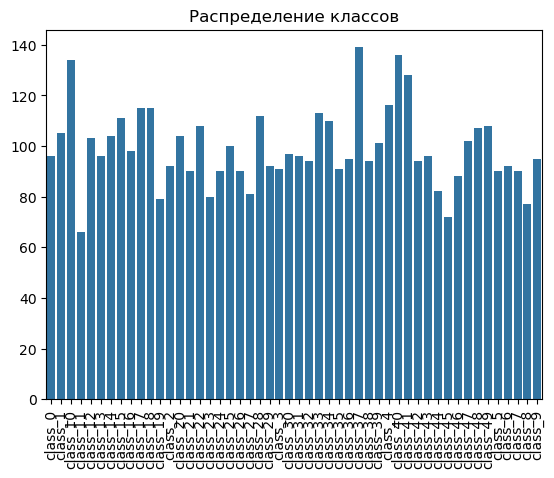

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from torchvision import datasets

train = 'butterflies-classification/train_butterflies/train_split'
test = 'butterflies-classification/test_butterflies/valid'

classes = os.listdir(train)
classes_cnt = len(classes)
print(f"Количество классов: {classes_cnt}")

class_counts = {cls: len(os.listdir(os.path.join(train, cls))) for cls in classes}
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Распределение классов")
plt.show()

**2. Подготовка данных**

Сделаем аугментации и нормализацию тренировачного датасета для увеличения обобщающей способности модели, разобъем тренировачную выборку на train и val. Для тестового датасета только нормалицазию и ресайз, чтобы не менять изображения

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

#Делаем аугментацию и препроцессинг
train_transforms = transforms.Compose([
    transforms.Resize((224 + 32, 224 + 32)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #были предварительно рассчитаны на датасете ImageNet
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #были предварительно рассчитаны на датасете ImageNet
])

class TestDataset(Dataset):
    def __init__(self, test, transform=None):
        self.test = test
        self.transform = transform
        self.image_files = sorted(
            [f for f in os.listdir(test) if f.endswith('.jpg')],
            key=lambda x: int(x.split('.')[0])
        )

    def __len__(self):
        return len(self.image_files)
    #Возвращаем пару: image, index
    def __getitem__(self, idx):
        img_name = os.path.join(self.test, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, int(self.image_files[idx].split('.')[0])

train_full = datasets.ImageFolder(train, transform=train_transforms)
train_size = int(0.9 * len(train_full))
val_size = len(train_full) - train_size
train_set, val_set = random_split(train_full, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(TestDataset(test, transform=test_transforms), batch_size=32, shuffle=False, num_workers=0)

**3. Реализация моделей**

Реализуем простую сверточную нейроную сетку, а также 2 предобученные модели: MobileNetV2 и EfficientNetB0

In [4]:
import torch.nn as nn
import torchvision.models as models

# Простая CNN
class SimpleCNN(nn.Module):
    def __init__(self, classes_cnt):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, classes_cnt)
        )

    def forward(self, x):
        return self.net(x)

# MobileNetV2
def build_mobilenet(classes_cnt):
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, classes_cnt)
    return model

# EfficientNetB0
def build_efficientnet(classes_cnt):
    model = models.efficientnet_b0(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, classes_cnt)
    return model

**4. Обучение и валидация**

In [ ]:
from tqdm.auto import tqdm

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    model = model.to('cuda')
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in tqdm(train_loader, desc=f'Train Epoch {epoch+1}'):
            images, labels = images.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        print(f"Epoch {epoch+1}: Train Acc={train_acc}, Val Acc={val_acc}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)
    return model, best_acc


@torch.no_grad()
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    for images, labels in tqdm(val_loader, desc='Validation'):
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return val_loss / total, correct / total

C:\Users\Игнат\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**5. Предсказания**

In [6]:
import pandas as pd
import torch.nn.functional as F

@torch.no_grad()
def create_submission(model, test_loader, train_dataset):
    model.eval()
    predictions = []
    indices = []
    idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
    for images, idxs in tqdm(test_loader, desc="Creating submission"):
        images = images.to('cuda')
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        indices.extend(idxs.cpu().numpy())

    submission = pd.DataFrame({
        "index": indices,
        "label": [p for p in predictions]
    }).sort_values("index")
    submission.to_csv("submission.csv", index=False)
    return submission

**6. Запуск обучения с разными моделями**

In [ ]:
# Список моделей
models_to_train = {
    "SimpleCNN": SimpleCNN(classes_cnt),
    "MobileNetV2": build_mobilenet(classes_cnt),
    "EfficientNetB0": build_efficientnet(classes_cnt)
}

model_scores = {}
model_submissions = {}

for model_name, model in models_to_train.items():
    print(f"\nОбучаем модель: {model_name}")
    trained_model, val_acc = train_model(model, train_loader, val_loader, epochs=10)
    model_scores[model_name] = val_acc
    submission = create_submission(trained_model, test_loader, train_full)
    model_submissions[model_name] = submission
    submission.to_csv(f"submission_{model_name}.csv", index=False)

best_model_name = max(model_scores, key=model_scores.get)
best_submission = model_submissions[best_model_name]

print(f"\nЛучшая модель: {best_model_name} с точностью {model_scores[best_model_name]}")

e:\Anaconda\envs\pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
e:\Anaconda\envs\pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weigh


Обучаем модель: SimpleCNN


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.83it/s]


Epoch 1: Train Acc=0.0206, Val Acc=0.0081


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.46it/s]


Epoch 2: Train Acc=0.0249, Val Acc=0.0302


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.61it/s]


Epoch 3: Train Acc=0.0235, Val Acc=0.0222


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.67it/s]


Epoch 4: Train Acc=0.0276, Val Acc=0.0222


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.57it/s]


Epoch 5: Train Acc=0.0274, Val Acc=0.0222


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.63it/s]


Epoch 6: Train Acc=0.0276, Val Acc=0.0222


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.63it/s]


Epoch 7: Train Acc=0.0475, Val Acc=0.1149


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.66it/s]


Epoch 8: Train Acc=0.1193, Val Acc=0.1452


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.46it/s]


Epoch 9: Train Acc=0.1675, Val Acc=0.2198


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.65it/s]


Epoch 10: Train Acc=0.2162, Val Acc=0.2641


Creating submission: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]



Обучаем модель: MobileNetV2


Validation: 100%|██████████| 16/16 [00:02<00:00,  8.00it/s]


Epoch 1: Train Acc=0.6889, Val Acc=0.8024


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.99it/s]


Epoch 2: Train Acc=0.8520, Val Acc=0.8569


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.07it/s]


Epoch 3: Train Acc=0.8672, Val Acc=0.8790


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.79it/s]


Epoch 4: Train Acc=0.9018, Val Acc=0.8448


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.27it/s]


Epoch 5: Train Acc=0.8892, Val Acc=0.8327


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.18it/s]


Epoch 6: Train Acc=0.9128, Val Acc=0.9093


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.25it/s]


Epoch 7: Train Acc=0.9211, Val Acc=0.8911


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.27it/s]


Epoch 8: Train Acc=0.9222, Val Acc=0.8750


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.22it/s]


Epoch 9: Train Acc=0.9267, Val Acc=0.8750


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.30it/s]


Epoch 10: Train Acc=0.9327, Val Acc=0.8851


Creating submission: 100%|██████████| 8/8 [00:00<00:00, 15.10it/s]



Обучаем модель: EfficientNetB0


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.60it/s]


Epoch 1: Train Acc=0.7511, Val Acc=0.8690


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.85it/s]


Epoch 2: Train Acc=0.8935, Val Acc=0.9012


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.90it/s]


Epoch 3: Train Acc=0.9300, Val Acc=0.9153


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.90it/s]


Epoch 4: Train Acc=0.9343, Val Acc=0.9173


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.92it/s]


Epoch 5: Train Acc=0.9448, Val Acc=0.8972


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.97it/s]


Epoch 6: Train Acc=0.9545, Val Acc=0.9153


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.90it/s]


Epoch 7: Train Acc=0.9578, Val Acc=0.9093


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.90it/s]


Epoch 8: Train Acc=0.9603, Val Acc=0.8952


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.91it/s]


Epoch 9: Train Acc=0.9560, Val Acc=0.9456


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.92it/s]


Epoch 10: Train Acc=0.9650, Val Acc=0.9173


Creating submission: 100%|██████████| 8/8 [00:00<00:00, 14.62it/s]


Лучшая модель: EfficientNetB0 с точностью 0.9455645161290323


**Лучший результат в каком-то из прогонов был такой**

![Снимок экрана 2025-07-06 194232.png](<attachment:Снимок экрана 2025-07-06 194232.png>)
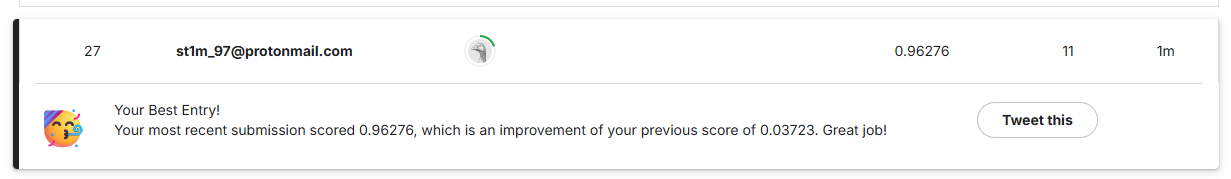